## Setup and import some libraries

In [1]:
# !pip install wheel==0.38.4
# !pip install setuptools==65
# !pip install gym==0.21
# !pip install torchrl
# pip install stable-baselines3[extra]
# !pip install torchvision
# !pip install gym==0.21
# !pip install --upgrade ipykernel
# !pip install matplotlib
# !pip install gym[atari,accept-rom-license]==0.21.0
# !pip install joblib
# !pip install tqdm

In [2]:
from IPython.display import clear_output
from PIL import Image
import matplotlib.pyplot as plt
import gym
import torchvision
import numpy as np
import torchrl
import torch
import tqdm
from torchrl.envs import *
from torchrl.envs.libs.gym import *
from joblib import Parallel, delayed
import warnings
from multiprocessing import Pool
warnings.filterwarnings('ignore')

torch.manual_seed(21)
np.random.seed(21)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
gym.version.VERSION

'0.21.0'

# So now we want destroy Assault

In [4]:
_env = gym.make("ALE/Assault-v5").env

n_actions = _env.action_space.n # see more info in actions.txt

print("n_actions =", n_actions)

from torchrl.envs import *
from torchrl.envs.libs.gym import *


env = TransformedEnv(
    GymEnv("ALE/Assault-v5", from_pixels=True),
    Compose(
        ToTensorImage(in_keys=["pixels"], out_keys=["pixels_trsf"]),
        Resize(in_keys=["pixels_trsf"], w=84, h=84),
        GrayScale(in_keys=["pixels_trsf"]),
        FrameSkipTransform(4), 
        ExcludeTransform("pixels")
    ),
).to(device) # our tranformed environment

state = env.reset()

print(state)

n_actions = 7
TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        pixels_trsf: Tensor(shape=torch.Size([1, 84, 84]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


## Итак, так выглядит уже измененная среда

torch.Size([1, 84, 84])


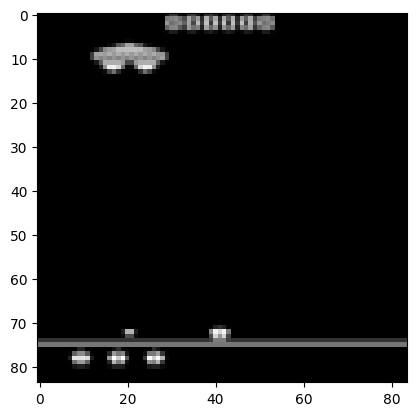

In [5]:
state = env.reset()

print(state['pixels_trsf'].shape)

plt.imshow(state['pixels_trsf'].cpu().permute(1, 2, 0), cmap="gray")

### Бро, тебе надо больше тренироваться

In [6]:
from agent import Agent
from constants import *


agent = Agent(num_channels=NUM_CHANNELS, width=W, height=H, n_actions=n_actions)

epoch = 0
eps = 1
Loss = []
Reward = []
t_max = 1000

784
784


Добавим сохранение и загрузку модели

In [7]:
def load():
    global epoch, Loss, eps, Reward
    checkpoint = torch.load('model.pth', map_location=torch.device(device))
    agent.model.load_state_dict(checkpoint['model'])
    agent.optimizer.load_state_dict(checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    Loss = checkpoint['loss']
    t_max = checkpoint['t_max']
    Reward = checkpoint['reward']
    eps = checkpoint['epsilon']

In [8]:
def save():
    torch.save({
        'epoch': epoch,
        'model': agent.model.state_dict(),
        'loss': Loss,
        'reward': Reward,
        'optimizer': agent.optimizer.state_dict(),
        'epsilon': eps,
        't_max': t_max
        }, 'model.pth')

Добавим для наглядности графики

In [9]:
def plot(L, R):
    clear_output(True)
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.plot(R)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(L)
    plt.show()

In [10]:
def session(agent, t_max=(int)(1e5), epsilon=0):
    env = TransformedEnv(
    GymEnv("ALE/Assault-v5", from_pixels=True),
        Compose(
            ToTensorImage(in_keys=["pixels"], out_keys=["pixels_trsf"]),
            Resize(in_keys=["pixels_trsf"], w=W, h=H),
            GrayScale(in_keys=["pixels_trsf"]),
            FrameSkipTransform(4), 
            ExcludeTransform("pixels")
        ),
    ).to(device)

    total_reward = 0
    state = env.reset()

    cnt = 0

    for t in range(t_max):
        action = agent.select_action(state['pixels_trsf'], epsilon=epsilon)

        state['action'] = torch.zeros(n_actions)
        state['action'][action] = 1

        next_state = env.step(state)['next']

        next_state['done'] = next_state['done'] + next_state['terminated'] + next_state['truncated']

        next_state.pop('truncated', None)
        next_state.pop('terminated', None)

        state['next'] = next_state

        agent.record_experience(state)

        total_reward += next_state['reward']

        state = next_state

        cnt += 1

        if cnt == 4:
            Loss.append(agent.train(batch_size=32))
            cnt = 0

        if next_state['done']:
            break
    
    return total_reward

In [11]:
num_sessions = (NUM_SESSIONS_CUDA if device == "cuda" else NUM_SESSIONS_CPU)

if training:
    if loading:
        load()
    
    save()

    print("preparing (add random states to replay buffer)")
    if not loading:
        pass
    else:
        Parallel(n_jobs=-1, require='sharedmem', verbose=30)(delayed(session)(agent, epsilon=0.3) for _ in range(pre_training_iterations))

    while True:
        print("Loss", Loss[-10:])
        rewards_for_session = [session(agent, t_max=(int)(t_max), epsilon=eps) for _ in range(num_sessions)]
        rewards_for_session = np.asarray(torch.as_tensor(rewards_for_session).cpu())

        eps *= 0.98

        Reward.append(np.mean(rewards_for_session))

        clear_output(True)
        plot(Loss, Reward)
        print("for epoch = ", epoch, ", epsilon = ", eps)

        if eps < 0.1:
            eps = 0.1
        
        t_max *= 1.01
        epoch += 1
        t_max = min(t_max, (int)(2e4))

        if epoch % 3 == 1:
            save()
            print('saved successfully')
        

preparing (add random states to replay buffer)
Loss []


In [ ]:
if not training:
    pass # lets see result!